In [1]:
from mpl_rcParams import * 

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.plasma_r

from scaling_lib.mode_solver import solve_modes
from scaling_lib.simulation_tdwg_repo import WaveguideSimulationWithBackground
from scaling_lib.misc_helpers import smoothen_waveguide

## Solve for modes of step-index waveguide

In [2]:
λ0 = 1.55 #um
ncore = 1.8
nclad = 1.7 
dn_wg = ncore-nclad

d_singlemode = λ0/2/np.sqrt(ncore**2-nclad**2)
k0 = 2*np.pi/λ0

Nmodes = 3
d_wg = 1.5*Nmodes

In [3]:
Lx = d_wg + 30
Nx = 2**8 #Be power of 2 for FFT

x_axis = np.linspace(-Lx/2, Lx/2, Nx)
x2ind = lambda x: np.argmin(np.abs(x_axis-x))

In [4]:
dn_wg_slice = 0*np.ones(Nx)
dn_wg_slice[x2ind(-d_wg/2):x2ind(d_wg/2)] = dn_wg
dn_wg_slice = smoothen_waveguide(x_axis, dn_wg_slice, nclad * k0)

In [5]:
betas, Evecs = solve_modes(x_axis, nclad, k0, dn_wg_slice, Nmodes)

In [6]:
fig_height = 1

Text(0.5, 0, '$x$ (um)')

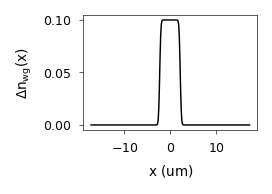

In [7]:
fig, ax = plt.subplots(figsize=(1.5, fig_height))

plt.plot(x_axis, dn_wg_slice, "k")
plt.ylabel(r"$\Delta n_{wg}(x)$")
plt.xlabel(r"$x$ (um)")

Text(0, 0.5, '$E_i(x)$')

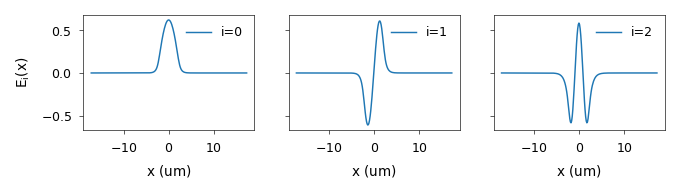

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(5, fig_height), sharey=True)
for (i, ax) in enumerate(axs):
    plt.sca(ax)
    plt.plot(x_axis, np.real(Evecs[i]), label=f"i={i}")
    plt.xlabel(r"$x$ (um)")
    plt.legend()
    
plt.sca(axs[0])
plt.ylabel(r"$E_i(x)$")

## Simulate modes in unperturbed waveguide

In [9]:
dz = 0.2
Lz = 3e2
N_com = 10

Nz = int(np.round((Lz/dz)))
z_axis = (np.arange(Nz)+1)*dz
z2ind = lambda z: np.argmin(np.abs(z_axis-z))

In [10]:
device = "cpu"
wg = WaveguideSimulationWithBackground(nclad, x_axis, z_axis, Ncom=1)

x = torch.eye(Nmodes, dtype=torch.complex64).to(device)
input_modes = torch.from_numpy(Evecs).to(device, dtype=torch.complex64)
input_beams = x@input_modes

wg.set_background_delta_n(torch.from_numpy(dn_wg_slice))
wg.run_simulation_slow(input_beams, torch.zeros(wg.Nz, wg.Nx));

Emat_x = wg.Emat_x
z_list = wg.z_list

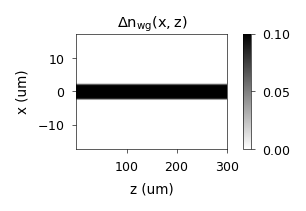

In [11]:
fig_height = 1
fig, axs = plt.subplots(1, 2, figsize=(1.5, fig_height), gridspec_kw={'width_ratios': [20, 1]})

plt.sca(axs[0])
img = plt.pcolormesh(z_axis, x_axis, np.tile(dn_wg_slice, (Nz,1)).T, cmap="binary")
plt.xlabel("z (um)")
plt.ylabel("x (um)")
plt.title(r"$\Delta n_{wg}(x, z)$", fontsize=7, pad=0)

plt.sca(axs[1])
plt.colorbar(img, cax=axs[1])

Text(0.5, 1.02, 'Real(E(x, z))')

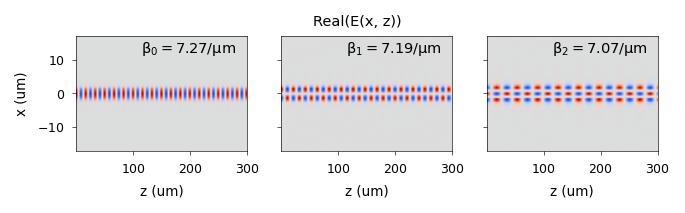

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(5, fig_height), sharey=True)

for i in range(Nmodes):
    plt.sca(axs[i])
    Ex_i = Emat_x[:, i, :]
    img = plt.pcolormesh(z_list, x_axis, torch.real(Ex_i).T, cmap="coolwarm")
    plt.xlabel("z (um)")
    plt.text(0.38, 0.85, rf"$\beta_{{{i}}} = ${np.real(betas[i]):.2f}/$\mu m$", transform=axs[i].transAxes)

plt.sca(axs[0])
plt.ylabel("x (um)")
plt.suptitle("Real(E(x, z))", y=1.02, fontsize=7)